In [17]:
import torch
import torchvision
import torch.nn as nn
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


### children(), named_children(), modules(), named_modules() 설명

**children()**<br>
해당 모듈의 직계 자식만 포함, 자기 자신의 포함하지 않음.<br>
모듈만 반환, iterator

**named_children()**<br>
역시 해당 모듈의 직계 자식만 포함하고 자기 자신을 포함하지 않나,<br>
(이름, 모듈) 의 튜플 형태로 반환, iterator

**modules()**<br>
자기 자신을 포함해서 모든 하위 모듈을 포함함.<br>
반환은 모듈만 반환, iterator

**named_modules()**<br>
자기 자신을 포함해서 모든 하위 모듈을 포함하고,<br>
(이름, 모듈) 의 튜플 형태로 반환, iterator

In [18]:
def get_all_layers(model):
    """모든 leaf 레이어들을 순서대로 가져오기 - 경로와 함께"""
    all_layers = []
    
    def collect_leaves(module, prefix=''):
        for name, child in module.named_children():
            full_name = f"{prefix}.{name}" if prefix else name
            
            if len(list(child.children())) == 0:
                all_layers.append((full_name, child))
            else:
                collect_leaves(child, prefix=full_name)
    
    collect_leaves(model)
    return all_layers

In [8]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import mnasnet1_0, MNASNet1_0_Weights
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

weights = SqueezeNet1_0_Weights.DEFAULT
model_squeezenet = squeezenet1_0(weights=weights)
model_squeezenet.eval()

weights = GoogLeNet_Weights.DEFAULT
model_googlenet = googlenet(weights=weights)
model_googlenet.eval()

weights = MobileNet_V2_Weights.DEFAULT
model_mobilenet = mobilenet_v2(weights=weights)
model_mobilenet.eval()


weights = MNASNet1_0_Weights.DEFAULT
model_mnasnet = mnasnet1_0(weights=weights)
model_mnasnet.eval()

models = {"squeezenet": model_squeezenet,
         "googlenet": model_googlenet,
         "mobilenet": model_mobilenet,
         "mnasnet": model_mnasnet}

models_original = copy.deepcopy(models)



for name, model in models.items():
    print(f"Model: {name}")
    print(f"Number of modules: {len(list(model.modules()))}")
    print(f"number of leaf layers: {len(get_all_layers(model))} ")
    print("-" * 40)


Model: squeezenet
Number of modules: 68
number of leaf layers: 57 
----------------------------------------
Model: googlenet
Number of modules: 224
number of leaf layers: 130 
----------------------------------------
Model: mobilenet
Number of modules: 213
number of leaf layers: 141 
----------------------------------------
Model: mnasnet
Number of modules: 182
number of leaf layers: 141 
----------------------------------------


In [9]:
class LaLaRAND:
    def __init__(self, model, device_sequence):
        self.model = model
        self.device_sequence = device_sequence
        self.current_device_index = 0
        self.all_layers = self._get_all_layers()

        if len(self.device_sequence) != len(self.all_layers):
            raise ValueError("레이어 수와 device 결정 순서가 일치하지 않음")

    def _get_all_layers(self):
        all_layers = []
        
        def recursive_children(module, parent=''):
            for name, child in module.named_children():
                if parent == False:
                    full_name = name
                else:
                    full_name = f"{parent}.{name}" 
                
                if len(list(child.children())) == 0:
                    all_layers.append((full_name, child))
                else:
                    recursive_children(child, parent=full_name)
        recursive_children(self.model)

        return all_layers
    
    

    

In [10]:
class LaLaRAND_test:
    def __init__(self, model, device_config):

        self.model = model
        self.device_config = device_config
        self.leaf_layers = self._get_leaf_layers()
        self.execution_times = {}
        
        # device 설정 길이와 레이어 수 확인
        if len(device_config) != len(self.leaf_layers):
            raise ValueError(f"Device config length ({len(device_config)}) must match number of leaf layers ({len(self.leaf_layers)})")
        
        self._setup_safe_hooks()
    
    def _get_leaf_layers(self):
        leaves = []
        
        def collect_leaves(module, prefix=''):
            for name, child in module.named_children():
                full_name = f"{prefix}.{name}" if prefix else name
                
                if len(list(child.children())) == 0:
                    leaves.append((full_name, child))
                else:
                    collect_leaves(child, prefix=full_name)
        
        collect_leaves(self.model)
        return leaves
    
    def _setup_safe_hooks(self):
        for i, (layer_name, layer) in enumerate(self.leaf_layers):
            device_type = self.device_config[i]
            
            # Pre-hook: 레이어와 입력을 같은 device로 이동
            def make_pre_hook(dev_type):
                def pre_hook(module, input):
                    # 시간 측정 
                    # gpu는 비동기여서 시간 측정을 위해 지금까지의 모든 gpu작업이 끝나도록 동기화해야함
                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 
                    else: 
                        None
                    
                    start_time = time.time()
                    module._start_time = start_time
                    
                    # Target device 결정
                    if dev_type == 0:
                        target_device = 'cpu'
                    else:
                        target_device = 'cuda'  
                    
                    # 레이어를 target device로 이동
                    module.to(target_device)
                    
                    if isinstance(input, tuple):
                        result = []  # 결과를 저장할 리스트
                        for inp in input:
                            if torch.is_tensor(inp):
                                result.append(inp.to(target_device))  # 텐서면 원하는 device로 이동
                            else:
                                result.append(inp)  # 텐서가 아니면 그대로 둠

                        return tuple(result)  # 리스트를 튜플로 변환해서 반환
                    else: 
                        if torch.is_tensor(input):
                            input = input.to(target_device)

                    return input

                return pre_hook
            
            # Post-hook: 실행시간 측정 및 다음 레이어 준비
            def make_post_hook(idx, name, dev_type):
                def post_hook(module, input, output):
                    # 시간 측정 종료
                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 
                    else: 
                        None
                    end_time = time.time()
                    execution_time = (end_time - module._start_time) * 1000  # ms로 변환
                    
                    # 실행시간 저장
                    device_name = "CPU" if dev_type == 0 else "GPU"
                    self.execution_times[f"Layer_{idx:02d}_{name}"] = {'time_ms': execution_time, 
                                                                       'device': device_name}
                    
                    return output.to("cuda")
                    
                return post_hook
            
            # Hook 등록
            layer.register_forward_pre_hook(make_pre_hook(device_type))
            layer.register_forward_hook(make_post_hook(i, layer_name, device_type))
            
    
    def forward(self, x):
        
        if self.device_config[0] == 0:
            first_device = 'cpu'
        else:
            first_device = 'cuda'

        x = x.to(first_device)
        
        self.model.eval()
        with torch.inference_mode():
            output = self.model(x)
            output.to("cuda") 
        
        return output
    
    def print_execution_report(self):
        """실행시간 리포트 출력"""
        print("\n" + "="*80)
        print("LAYER EXECUTION REPORT")
        print("="*80)
        print(f"{'Layer':<30} {'Device':<10} {'Time (ms)':<15}")
        print("-"*80)
        
        total_time = 0
        cpu_time = 0
        gpu_time = 0
        
        for layer_name, info in self.execution_times.items():
            time_ms = info['time_ms']
            device = info['device']
            
            print(f"{layer_name:<30} {device:<10} {time_ms:<15.4f}")
            
            total_time += time_ms
            if device == "CPU":
                cpu_time += time_ms
            else:
                gpu_time += time_ms
        
        print("-"*80)
        print(f"{'TOTAL':<30} {'MIXED':<10} {total_time:<15.4f}")
        print(f"{'CPU TOTAL':<30} {'CPU':<10} {cpu_time:<15.4f}")
        print(f"{'GPU TOTAL':<30} {'GPU':<10} {gpu_time:<15.4f}")
        print("="*80)
    
    


In [ ]:
for name in models.keys():
    print(f"\n\n🔍 Testing model: {name}")
    models[name] = copy.deepcopy(models_original[name]) # 원본 모델로 복원
    models[name].eval()  # 평가 모드로 설정
    models[name].to("cuda")  # GPU로 이동

    num_layers = len(get_all_layers(models[name]))
    baseline_device_config = [1] * num_layers  # 모든 레이어 GPU
    
    # baseline 측정
    controller = LaLaRAND_test(models[name], baseline_device_config)
    dummy_input = torch.randn(1, 3, 224, 224)  # ImageNet 크기
    controller.forward(dummy_input)
    controller.print_execution_report()
    

    # 하나씩 CPU로 옮기며 시간 측정
    for i in range(num_layers):
        print(f"\n[TEST] Moving layer {i} to CPU...")
        test_config = [1] * num_layers
        test_config[i] = 0  # 해당 레이어만 CPU

        controller = LaLaRAND_test(models[name], test_config)
        controller.forward(dummy_input)
        controller.print_execution_report()
        models[name] = copy.deepcopy(models_original[name]) 




🔍 Testing model: squeezenet

LAYER EXECUTION REPORT
Layer                          Device     Time (ms)      
--------------------------------------------------------------------------------
Layer_00_features.0            GPU        127.0998       
Layer_01_features.1            GPU        10.9365        
Layer_02_features.2            GPU        0.6881         
Layer_03_features.3.squeeze    GPU        23.6783        
Layer_04_features.3.squeeze_activation GPU        0.0763         
Layer_05_features.3.expand1x1  GPU        5.6834         
Layer_06_features.3.expand1x1_activation GPU        0.0629         
Layer_07_features.3.expand3x3  GPU        3.2184         
Layer_08_features.3.expand3x3_activation GPU        0.0508         
Layer_09_features.4.squeeze    GPU        3.9382         
Layer_10_features.4.squeeze_activation GPU        0.0482         
Layer_11_features.4.expand1x1  GPU        0.1321         
Layer_12_features.4.expand1x1_activation GPU        0.0389         
Layer_1

/root/miniconda3/envs/good/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



LAYER EXECUTION REPORT
Layer                          Device     Time (ms)      
--------------------------------------------------------------------------------
Layer_00_conv1.conv            GPU        2.8033         
Layer_01_conv1.bn              GPU        1.4195         
Layer_02_maxpool1              GPU        0.0777         
Layer_03_conv2.conv            GPU        3.1543         
Layer_04_conv2.bn              GPU        0.1423         
Layer_05_conv3.conv            GPU        5.1856         
Layer_06_conv3.bn              GPU        0.5903         
Layer_07_maxpool2              GPU        0.1602         
Layer_08_inception3a.branch1.conv GPU        3.0663         
Layer_09_inception3a.branch1.bn GPU        0.1459         
Layer_10_inception3a.branch2.0.conv GPU        2.7819         
Layer_11_inception3a.branch2.0.bn GPU        0.1490         
Layer_12_inception3a.branch2.1.conv GPU        3.3586         
Layer_13_inception3a.branch2.1.bn GPU        0.1304         
Layer

🏃‍♂️ Running Simple Performance Comparison...

🔍 Testing model: squeezenet
📊 Baseline (All GPU)...
✅ Baseline: 8.10 ms
🧪 Layer 0 on CPU...
   9.32 ms (1.15x)
🧪 Layer 1 on CPU...
   8.71 ms (1.08x)
🧪 Layer 2 on CPU...
   8.49 ms (1.05x)
🧪 Layer 3 on CPU...
   7.45 ms (0.92x)
🧪 Layer 4 on CPU...
   6.65 ms (0.82x)
🧪 Layer 5 on CPU...
   7.48 ms (0.92x)
🧪 Layer 6 on CPU...
   7.00 ms (0.86x)
🧪 Layer 7 on CPU...
   7.52 ms (0.93x)
🧪 Layer 8 on CPU...
   7.01 ms (0.87x)
🧪 Layer 9 on CPU...
   7.77 ms (0.96x)
🧪 Layer 10 on CPU...
   6.69 ms (0.83x)
🧪 Layer 11 on CPU...
   7.34 ms (0.91x)
🧪 Layer 12 on CPU...
   7.09 ms (0.88x)
🧪 Layer 13 on CPU...
   7.28 ms (0.90x)
🧪 Layer 14 on CPU...
   7.08 ms (0.87x)
🧪 Layer 15 on CPU...
   7.71 ms (0.95x)
🧪 Layer 16 on CPU...
   6.94 ms (0.86x)
🧪 Layer 17 on CPU...
   7.54 ms (0.93x)
🧪 Layer 18 on CPU...
   7.53 ms (0.93x)
🧪 Layer 19 on CPU...
   7.72 ms (0.95x)
🧪 Layer 20 on CPU...
   8.05 ms (0.99x)
🧪 Layer 21 on CPU...
   8.08 ms (1.00x)
🧪 Layer 22 

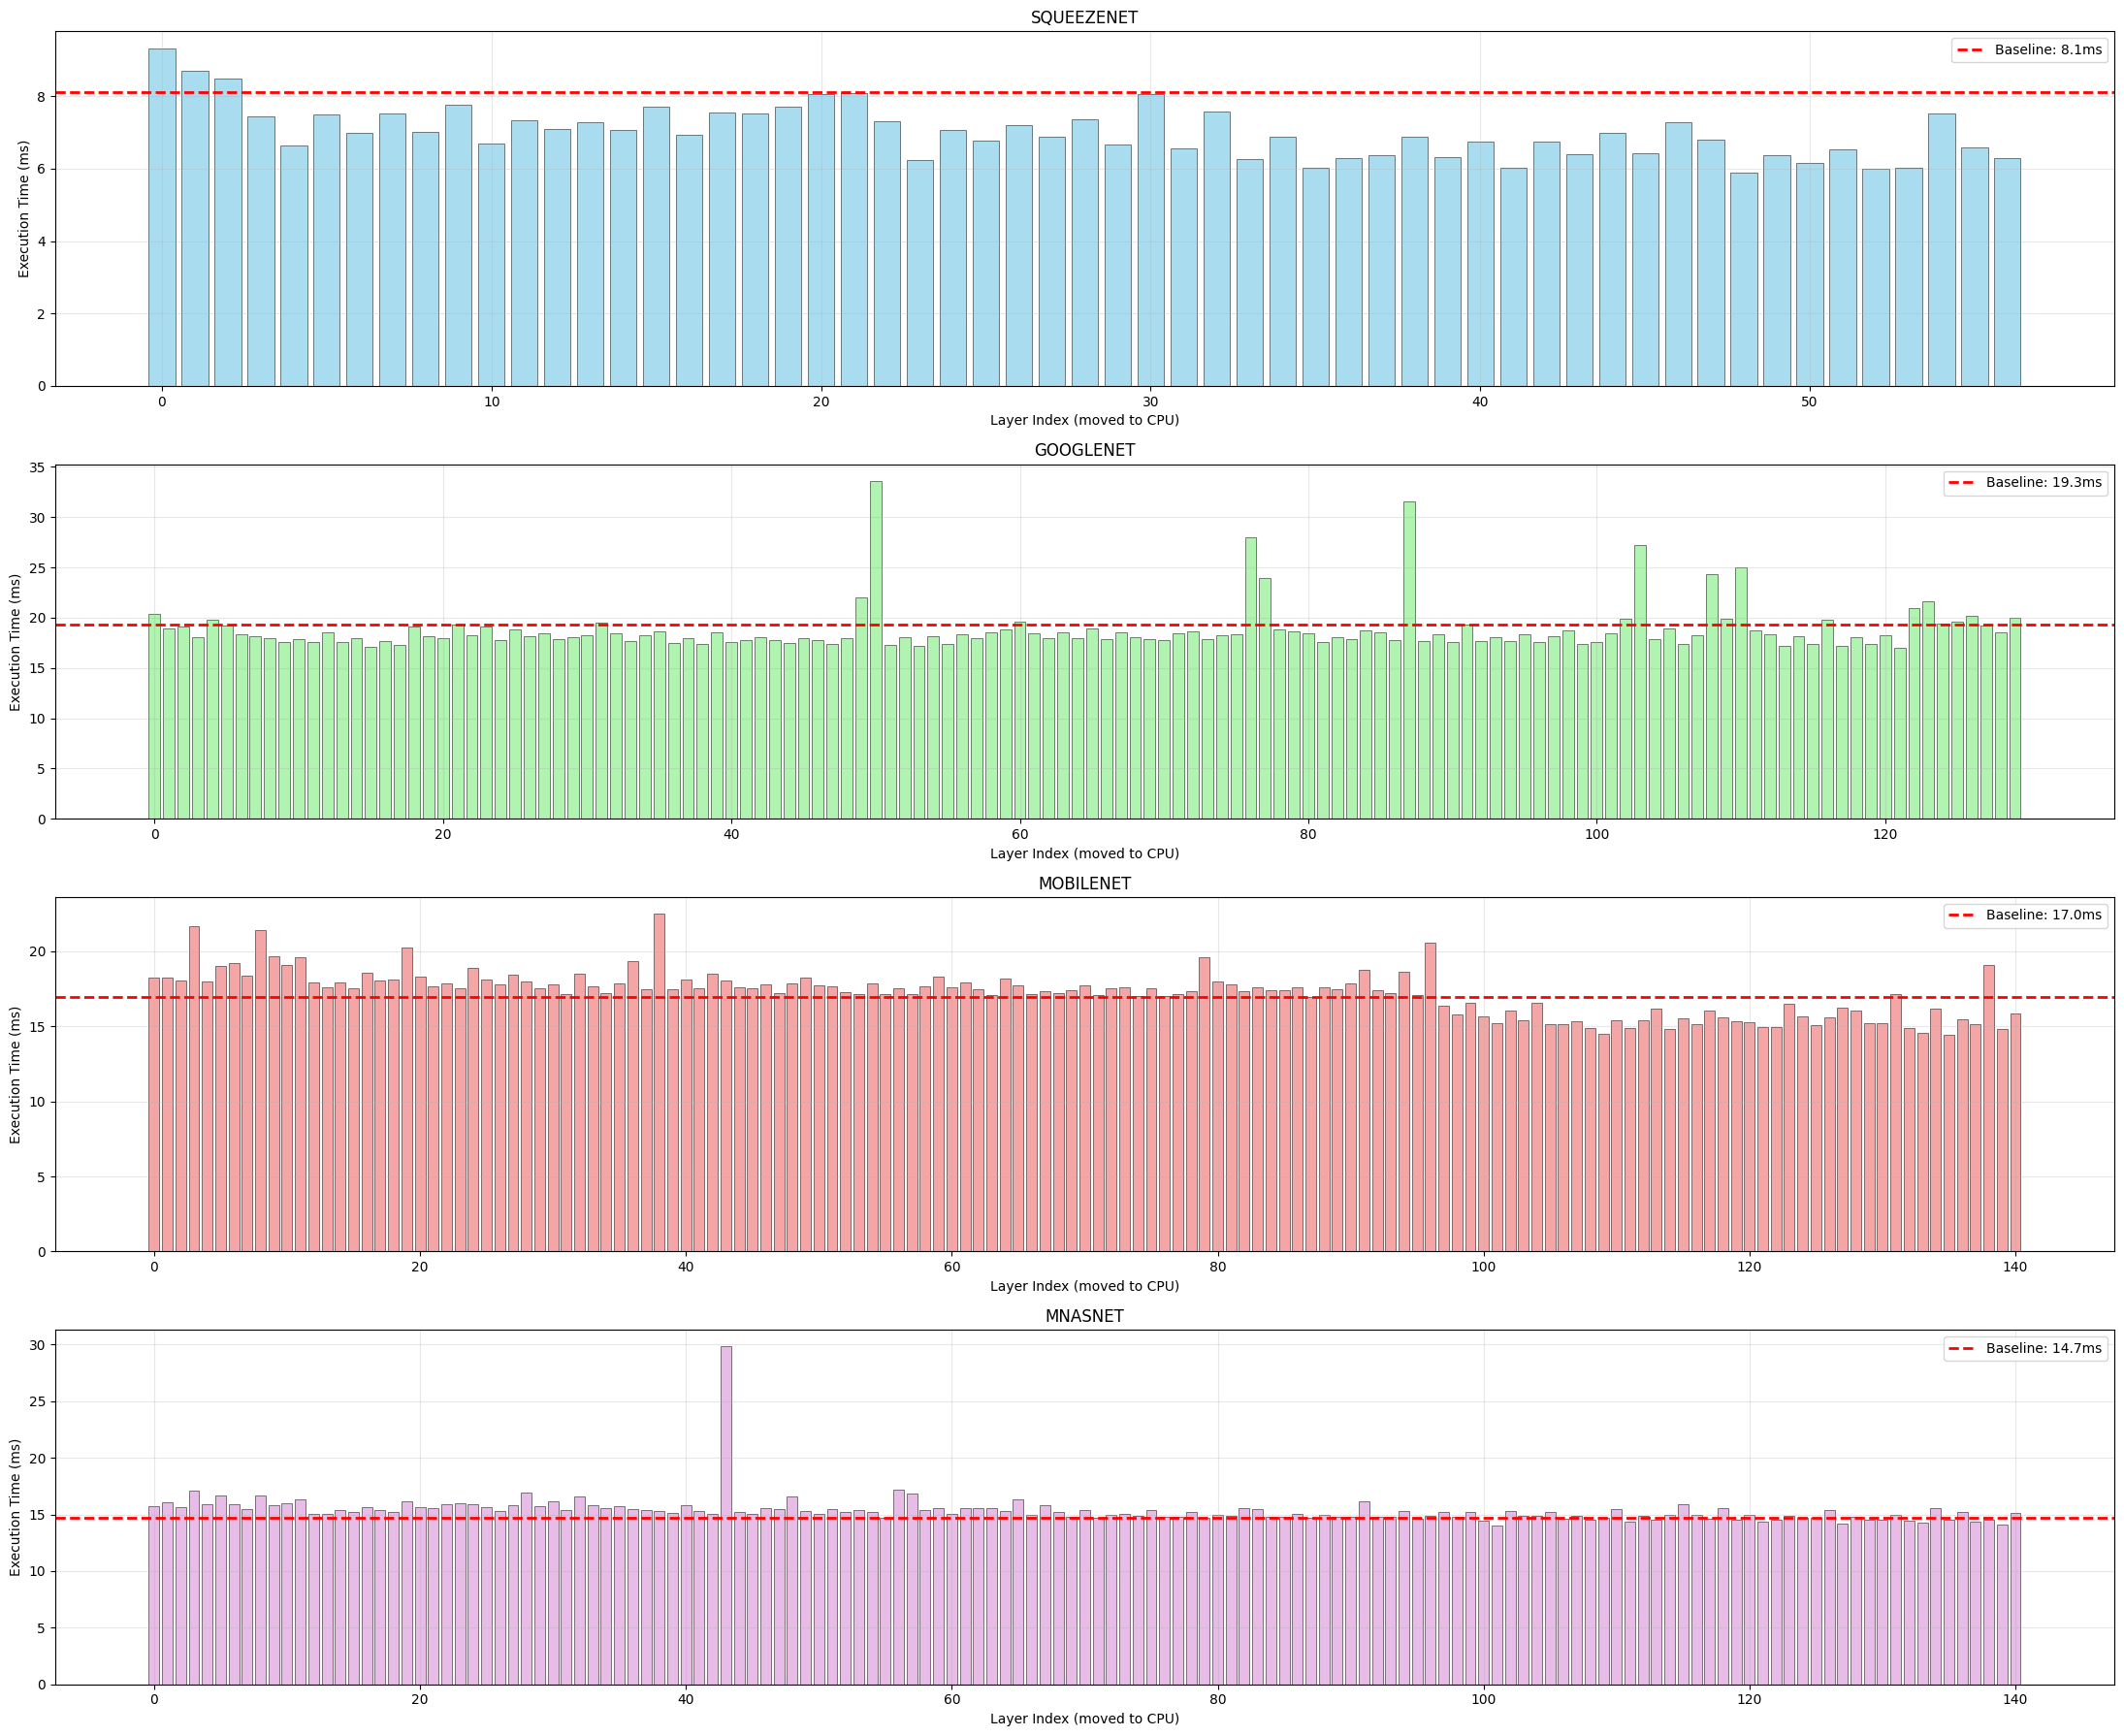


SIMPLE PERFORMANCE SUMMARY
Model        Baseline(ms) Worst(ms)    Worst Layer 
------------------------------------------------------------
squeezenet   8.1          9.3          0           
googlenet    19.3         33.6         50          
mobilenet    17.0         22.5         38          
mnasnet      14.7         29.8         43          


In [25]:
# 🎯 간단한 베이스라인 vs 레이어별 실행시간 비교

def simple_performance_comparison():
    """베이스라인과 각 레이어 CPU 이동시 실행시간 간단 비교"""
    
    all_results = {}
    
    for name in models.keys():
        print(f"\n🔍 Testing model: {name}")
        print("=" * 40)
        
        # 모델 복사 및 GPU 이동
        models[name] = copy.deepcopy(models_original[name])
        if torch.cuda.is_available():
            models[name].cuda()
        
        num_layers = len(get_all_layers(models[name]))
        dummy_input = torch.randn(1, 3, 224, 224)
        if torch.cuda.is_available():
            dummy_input = dummy_input.cuda()
        
        # 결과 저장
        layer_indices = []
        execution_times = []
        
        # 1. Baseline 측정 (모든 레이어 GPU)
        print("📊 Baseline (All GPU)...")
        models[name] = copy.deepcopy(models_original[name])
        if torch.cuda.is_available():
            models[name].cuda()
        
        baseline_config = [1] * num_layers
        controller = LaLaRAND_test(models[name], baseline_config)
        
        start_time = time.time()
        _ = controller.forward(dummy_input)
        baseline_time = (time.time() - start_time) * 1000
        
        print(f"✅ Baseline: {baseline_time:.2f} ms")
        
        # 베이스라인 저장
        layer_indices.append(-1)  # -1 = baseline
        execution_times.append(baseline_time)
        
        # 2. 각 레이어별 테스트
        for i in range(num_layers):
            print(f"🧪 Layer {i} on CPU...")
            
            # 새 모델 복사
            models[name] = copy.deepcopy(models_original[name])
            if torch.cuda.is_available():
                models[name].cuda()
            
            test_config = [1] * num_layers
            test_config[i] = 0  # i번째 레이어만 CPU
            
            controller = LaLaRAND_test(models[name], test_config)
            
            start_time = time.time()
            _ = controller.forward(dummy_input)
            test_time = (time.time() - start_time) * 1000
            
            # 결과 저장
            layer_indices.append(i)
            execution_times.append(test_time)
            
            print(f"   {test_time:.2f} ms ({test_time/baseline_time:.2f}x)")
        
        # 모델별 결과 저장
        all_results[name] = {
            'layer_indices': layer_indices,
            'execution_times': execution_times,
            'baseline_time': baseline_time
        }
        
        print(f"✅ {name} completed!")
    
    return all_results

def simple_visualization(results):
    """간단한 시각화"""
    
    num_models = len(results)
    fig, axes = plt.subplots(4, 1, figsize=(22, 18))
    axes = axes.flatten()
    
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
    
    for i, (model_name, data) in enumerate(results.items()):
        if i >= 4:  # 최대 4개 모델만
            break
            
        ax = axes[i]
        
        layer_indices = data['layer_indices'][1:]  # baseline 제외
        execution_times = data['execution_times'][1:]  # baseline 제외
        baseline_time = data['baseline_time']
        
        # 막대 그래프
        bars = ax.bar(layer_indices, execution_times, 
                     alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)
        
        # 베이스라인 선
        ax.axhline(y=baseline_time, color='red', linestyle='--', 
                  linewidth=2, label=f'Baseline: {baseline_time:.1f}ms')
        
        ax.set_xlabel('Layer Index (moved to CPU)')
        ax.set_ylabel('Execution Time (ms)')
        ax.set_title(f'{model_name.upper()}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    
    # 빈 subplot 숨기기
    for j in range(i+1, 4):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('/workspace/pytorch_bootcamp/simple_performance_comparison.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def print_simple_summary(results):
    """간단한 요약 테이블"""
    print("\n" + "="*60)
    print("SIMPLE PERFORMANCE SUMMARY")
    print("="*60)
    print(f"{'Model':<12} {'Baseline(ms)':<12} {'Worst(ms)':<12} {'Worst Layer':<12}")
    print("-"*60)
    
    for name, data in results.items():
        baseline = data['baseline_time']
        exec_times = data['execution_times'][1:]  # baseline 제외
        layer_indices = data['layer_indices'][1:]  # baseline 제외
        
        worst_time = max(exec_times)
        worst_layer = layer_indices[exec_times.index(worst_time)]
        
        print(f"{name:<12} {baseline:<12.1f} {worst_time:<12.1f} {worst_layer:<12}")
    
    print("="*60)

# 실행
print("🏃‍♂️ Running Simple Performance Comparison...")
simple_results = simple_performance_comparison()
simple_visualization(simple_results)
print_simple_summary(simple_results)

In [ ]:
class SafeLayerDeviceController:
    def __init__(self, model, device_config):
        """
        개선된 LayerDeviceController - 레이어와 데이터를 함께 이동
        
        model: PyTorch 모델
        device_config: 각 레이어의 device 설정 (0=CPU, 1=GPU)
                      예: [1, 1, 0, 0, 1] -> 1,2,5번째는 GPU, 3,4번째는 CPU
        """
        self.model = model
        self.device_config = device_config
        self.leaf_layers = self._get_leaf_layers()
        self.execution_times = {}
        self.hooks = []
        self.original_devices = {}  # 원래 device 저장
        
        # device 설정 길이와 레이어 수 확인
        if len(device_config) != len(self.leaf_layers):
            raise ValueError(f"Device config length ({len(device_config)}) must match number of leaf layers ({len(self.leaf_layers)})")
        
        self._setup_safe_hooks()
    
    def _get_leaf_layers(self):
        """모든 leaf 레이어들을 순서대로 가져오기"""
        leaves = []
        
        def collect_leaves(module, prefix=''):
            for name, child in module.named_children():
                full_name = f"{prefix}.{name}" if prefix else name
                
                if len(list(child.children())) == 0:
                    leaves.append((full_name, child))
                else:
                    collect_leaves(child, prefix=full_name)
        
        collect_leaves(self.model)
        return leaves
    
    def _setup_safe_hooks(self):
        """안전한 hook 설정 - 레이어와 데이터를 함께 이동"""
        for i, (layer_name, layer) in enumerate(self.leaf_layers):
            device_type = self.device_config[i]
            
            # 원래 device 저장
            if hasattr(layer, 'weight') and layer.weight is not None:
                self.original_devices[layer_name] = layer.weight.device
            
            # Pre-hook: 레이어와 입력을 같은 device로 이동
            def make_pre_hook(idx, name, dev_type, layer_ref):
                def pre_hook(module, input):
                    # 시간 측정 시작
                    torch.cuda.synchronize() if torch.cuda.is_available() else None
                    start_time = time.time()
                    module._start_time = start_time
                    
                    # Target device 결정
                    target_device = 'cpu' if dev_type == 0 else 'cuda'
                    
                    # 레이어를 target device로 이동
                    module.to(target_device)
                    
                    # 입력을 같은 device로 이동
                    if isinstance(input, tuple):
                        return tuple(inp.to(target_device) if torch.is_tensor(inp) else inp for inp in input)
                    else:
                        return input.to(target_device) if torch.is_tensor(input) else input
                        
                return pre_hook
            
            # Post-hook: 실행시간 측정 및 다음 레이어 준비
            def make_post_hook(idx, name, dev_type):
                def post_hook(module, input, output):
                    # 시간 측정 종료
                    torch.cuda.synchronize() if torch.cuda.is_available() else None
                    end_time = time.time()
                    execution_time = (end_time - module._start_time) * 1000  # ms로 변환
                    
                    # 실행시간 저장
                    device_name = "CPU" if dev_type == 0 else "GPU"
                    self.execution_times[f"Layer_{idx:02d}_{name}"] = {
                        'time_ms': execution_time,
                        'device': device_name
                    }
                    
                    return output.to("cuda")
                    
                return post_hook
            
            # Hook 등록
            pre_handle = layer.register_forward_pre_hook(make_pre_hook(i, layer_name, device_type, layer))
            post_handle = layer.register_forward_hook(make_post_hook(i, layer_name, device_type))
            
            self.hooks.extend([pre_handle, post_handle])
    
    def forward(self, x):
        """모델 실행"""
        self.execution_times.clear()
        
        # 첫 번째 레이어의 device에 맞게 입력 이동
        first_device = 'cpu' if self.device_config[0] == 0 else 'cuda'
        x = x.to(first_device)
        
        self.model.eval()
        with torch.inference_mode():
            output = self.model(x)
        
        return output
    
    def print_execution_report(self):
        """실행시간 리포트 출력"""
        print("\n" + "="*80)
        print("LAYER EXECUTION REPORT")
        print("="*80)
        print(f"{'Layer':<30} {'Device':<10} {'Time (ms)':<15}")
        print("-"*80)
        
        total_time = 0
        cpu_time = 0
        gpu_time = 0
        
        for layer_name, info in self.execution_times.items():
            time_ms = info['time_ms']
            device = info['device']
            
            print(f"{layer_name:<30} {device:<10} {time_ms:<15.4f}")
            
            total_time += time_ms
            if device == "CPU":
                cpu_time += time_ms
            else:
                gpu_time += time_ms
        
        print("-"*80)
        print(f"{'TOTAL':<30} {'MIXED':<10} {total_time:<15.4f}")
        print(f"{'CPU TOTAL':<30} {'CPU':<10} {cpu_time:<15.4f}")
        print(f"{'GPU TOTAL':<30} {'GPU':<10} {gpu_time:<15.4f}")
        print("="*80)
    
    def restore_model(self):
        """모델을 원래 device로 복원"""
        print("Restoring model to original state...")
        for layer_name, original_device in self.original_devices.items():
            for name, layer in self.leaf_layers:
                if name == layer_name:
                    layer.to(original_device)
                    break
        print("Model restored to original devices")
    
    def remove_hooks(self):
        """모든 hook 제거 및 모델 복원"""
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        self.restore_model()
        print("All hooks removed and model restored!")

In [10]:
import numpy as np

for name, model_instance in models.items():
    print(f"\n\n🔍 Testing model: {name}")
    
    num_layers = len(get_clean_leaf_layers(model_instance))
    baseline_device_config = [1] * num_layers  # 모든 레이어 GPU
    
    # baseline 측정
    controller = SafeLayerDeviceController(model_instance, baseline_device_config)
    dummy_input = torch.randn(1, 3, 224, 224)  # ImageNet 크기
    _ = controller.forward(dummy_input)
    controller.print_execution_report()
    controller.remove_hooks()

    # 하나씩 CPU로 옮기며 시간 측정
    for i in range(num_layers):
        print(f"\n[TEST] Moving layer {i} to CPU...")
        test_config = [1] * num_layers
        test_config[i] = 0  # 해당 레이어만 CPU

        controller = SafeLayerDeviceController(model_instance, test_config)
        _ = controller.forward(dummy_input)
        controller.print_execution_report()
        controller.remove_hooks()




🔍 Testing model: squeezenet

LAYER EXECUTION REPORT
Layer                          Device     Time (ms)      
--------------------------------------------------------------------------------
Layer_00_features.0            GPU        118.3126       
Layer_01_features.1            GPU        8.3232         
Layer_02_features.2            GPU        0.6988         
Layer_03_features.3.squeeze    GPU        24.0188        
Layer_04_features.3.squeeze_activation GPU        0.0734         
Layer_05_features.3.expand1x1  GPU        5.7566         
Layer_06_features.3.expand1x1_activation GPU        0.0653         
Layer_07_features.3.expand3x3  GPU        3.2325         
Layer_08_features.3.expand3x3_activation GPU        0.0520         
Layer_09_features.4.squeeze    GPU        3.8972         
Layer_10_features.4.squeeze_activation GPU        0.0498         
Layer_11_features.4.expand1x1  GPU        0.1726         
Layer_12_features.4.expand1x1_activation GPU        0.0410         
Layer_1

/root/miniconda3/envs/good/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



LAYER EXECUTION REPORT
Layer                          Device     Time (ms)      
--------------------------------------------------------------------------------
Layer_00_conv1.conv            GPU        2.4714         
Layer_01_conv1.bn              GPU        1.0972         
Layer_02_maxpool1              GPU        0.0575         
Layer_03_conv2.conv            GPU        3.5167         
Layer_04_conv2.bn              GPU        0.2122         
Layer_05_conv3.conv            GPU        5.4402         
Layer_06_conv3.bn              GPU        0.5007         
Layer_07_maxpool2              GPU        0.0532         
Layer_08_inception3a.branch1.conv GPU        2.5713         
Layer_09_inception3a.branch1.bn GPU        0.2162         
Layer_10_inception3a.branch2.0.conv GPU        2.4223         
Layer_11_inception3a.branch2.0.bn GPU        0.2055         
Layer_12_inception3a.branch2.1.conv GPU        3.6466         
Layer_13_inception3a.branch2.1.bn GPU        0.1936         
Layer